#### install MLFlow
!pip install mlflow

### Libraries

In [1]:
# DS libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler
from sklearn.metrics import *

# MLOps
import mlflow
import mlflow.sklearn

### Credit loans dataset

In [2]:
df = pd.read_csv('./Datasets/Credit.csv')
df.shape

(1000, 21)

In [3]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


### Preprocessing

In [4]:
# setting object variables to categorical and replace values to their respective categories
cat_vars = df.select_dtypes(include=['object']).columns
for column in cat_vars:
    df[column] = df[column].astype('category').cat.codes
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


### Splitting dataset in train and test subdatasets

In [5]:
predictors = df.iloc[:, 0:-1].values
predictors

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]])

In [6]:
dependet_class = df.iloc[:, -1].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(predictors, dependet_class, test_size=0.2, random_state=42)

### Creating Naive Bayes model

In [8]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

### Making predictions with the trained model

In [9]:
predict_values = model.predict(X_test)

In [10]:
predict_values_prob = model.predict_proba(X_test)
df_prob = pd.DataFrame(predict_values_prob, columns=['bad', 'good'])
df_prob.head()

,bad,good
0,0.394741,0.605259
1,0.296483,0.703517
2,0.564212,0.435788
3,0.480816,0.519184
4,0.404758,0.595242


### Performance Analysis - Metrics

In [11]:
acc = accuracy_score(y_test, predict_values)
ps = precision_score(y_test, predict_values)
rc = recall_score(y_test, predict_values)
fs = f1_score(y_test, predict_values)

In [12]:
print("Accuracy: {:.2f}% \nPrecision: {:.2f}% \nRecall: {:.2f}% \nF1-score: {:.2f}% \n".format(acc, ps, rc, fs))

Accuracy: 0.71% 
Precision: 0.78% 
Recall: 0.83% 
F1-score: 0.80% 



### Run experiment

Model:  active
Model:  1ccad7b289924cd7aeeee09cc7c2cae7


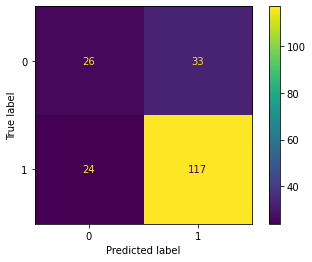

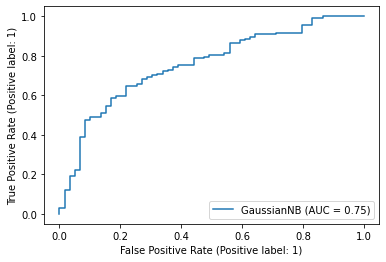

In [16]:
mlflow.set_experiment("nb_experiment")

with mlflow.start_run():
    # Model's implementation
    model = GaussianNB()
    model.fit(X_train, y_train)
    predict_values = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, predict_values)
    ps = precision_score(y_test, predict_values)
    rc = recall_score(y_test, predict_values)
    fs = f1_score(y_test, predict_values)
    auc = roc_auc_score(y_test, predict_values)

    metrics = {
                "accuracy": acc,
                "precision": ps,
                "recall": rc,
                "f1-score": fs
                }

    # Sign metrics
    mlflow.log_metrics(metrics=metrics)

    # Some graphs
    cfm = plot_confusion_matrix(model, X_test, y_test)
    plt.savefig("confusion_matrix.png")

    roc = plot_roc_curve(model, X_test, y_test)
    plt.savefig("roc_curve.png")

    # Sign graphs
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("roc_curve.png")

    mlflow.sklearn.log_model(model, "NaiveBayesModel")

    # Some run information
    print("Model: ", mlflow.active_run().info.lifecycle_stage)
    print("Model: ", mlflow.active_run().info.run_uuid)

mlflow.end_run()

